![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Introduction to Text Mining and Natural Language Processing

### Instructor: Hannes Mueller


## Session 5: Applications of Dictionary Methods

We will see an implementation of a dictionary method on a corpus now and after that dimensionality reduction with clustering and PCA.


### 1) Dictionary Methods: The EPU According to the Associated Press

We will implement a simple version of the Economic Policy Uncertainty (EPU) Index. This implementation is based on the approach of Corinna Ghirelli, Javier J. Pérez, and Alberto Urtasun, as detailed in their research.

 [Read their paper](https://econpapers.repec.org/article/eeeecolet/v_3a182_3ay_3a2019_3ai_3ac_3ap_3a64-67.htm)

 ### Terms Used in the EPU Index

 #### E Terms (Economic)
 - economic(s)
 - economy

 #### P Terms (Policy)
 - the name of the central bank of the country
 - the name of the government's workplace in the country
 - Parliament
 - Government
 - Federal Reserve
 - Treasury
 - tariff(s)
 - deficit(s)
 - budget(s)
 - public spending
 - debt ceiling
 - exchange rate(s)
 - currency crash(es)
 - sovereign debt
 - public debt
 - fiscal policy/policies
 - monetary policy/policies
 - legislation
 - reform(s)
 - tax(es)
 - overhaul
 - rule(s)
 - norm(s)
 - normative
 - regulation(s)
 - law(s)

 #### U Terms (Uncertainty)
 - uncertain
 - uncertainty/uncertainties
 - unstable
 - instability/instabilities
 - risk(s)


# Load Utilities for Pre-processing

In [2]:


import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

from scipy.stats import pearsonr

# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))




[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannesfelixmuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.6 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:


"""
This module provides helper functions for text preprocessing. 
Each function applies punctuation removal and stopword removal, and then one of three options:
    0: Lowercasing only.
    1: Lowercasing plus stemming.
    2: Lemmatizing (using spaCy; original casing is preserved).

The functions return a string of tokens separated by spaces.
"""

def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing punctuation and stopwords using spaCy's token attributes.
       - Lemmatizing the text.
       - (Note: This function does NOT lowercase the text.)
    
    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """
    doc = sp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']
    return " ".join(lemmatized_tokens)

def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")


# Load AP Corpus

In [4]:
path = "/Users/hannesfelixmuller/Dropbox/teaching/Text Mining DSDM 2025/Session6_EPU_PCA/"
corpus_data =pd.read_csv(path+'AP_spain_corpus.csv', encoding='utf-8',encoding_errors='ignore',index_col=0)
corpus_data.info()


<class 'pandas.DataFrame'>
Index: 13462 entries, 0 to 13474
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         13462 non-null  int64
 1   month        13462 non-null  str  
 2   day          13462 non-null  int64
 3   section      13449 non-null  str  
 4   text         13462 non-null  str  
 5   count        13462 non-null  int64
 6   is_sport     13462 non-null  bool 
 7   sport_dummy  13462 non-null  int64
dtypes: bool(1), int64(4), str(3)
memory usage: 854.5 KB


# Pre-process

We are only doing lowercasing now

In [6]:

# Set mode (0 = lowercasing, 1 = stemming, 2 = lemmatizing)
mod = 0

# Pre-process the text column with progress tracking
try:
    corpus_data["text_preproc"] = corpus_data.text.astype(str).progress_apply(lambda row: tokenize(row, mod))
    print("Done processing text.")
except Exception as e:
    print(f"Error processing text column: {e}")
    sys.exit(1)

100%|██████████| 13462/13462 [00:07<00:00, 1699.39it/s]

Done processing text.


In [7]:
print(corpus_data["text"][0])

The cry of a muezzin echoed from a hilltop overlooking the Alhambra as Granada, the former seat of Moorish rule in Spain, unveiled its first mosque in 511 years.Dignitaries from Arab and Muslim countries worldwide attended the opening Thursday of the Great Mosque of Granada, crowning a fitful and emotionally charged project that began in 1981.With repeated shouts of "Allahu Akhbar" (God is great), Sheik Sultan bin Mohammed al-Qassimi of the United Arab Emirates, which paid half the cost of construction, drew back a blood-red curtain to display a stone plaque inaugurating the building.Later, a muezzin clad in white climbed atop the mosque's thick, square minaret and called Muslims to prayer for the first time in their new house of worship."This is a moving day for Muslims all over the world," said Hassan Seddadi, a 25-year-old Moroccan who lives in Granada.It also comes at a sensitive time in Spain's relationship with its Muslim population, and with neighboring Muslim states across the 

In [8]:
print(corpus_data["text_preproc"][0])

cry muezzin echoed hilltop overlooking alhambra granada former seat moorish rule spain unveiled first mosque 511 yearsdignitaries arab muslim countries worldwide attended opening thursday great mosque granada crowning fitful emotionally charged project began 1981with repeated shouts allahu akhbar god great sheik sultan bin mohammed alqassimi united arab emirates paid half cost construction drew back bloodred curtain display stone plaque inaugurating buildinglater muezzin clad white climbed atop mosques thick square minaret called muslims prayer first time new house worshipthis moving day muslims world said hassan seddadi 25yearold moroccan lives granadait also comes sensitive time spains relationship muslim population neighboring muslim states across straits gibraltar worldwide hunt terrorists since sept 11 attacks led arrests muslims spain spanish government angered many muslims robust support war iraqthe mosque commands sweeping vista one historys prime pieces real estate alhambra re

 # Implement EPU method

Implement the EPU method as described in lecture but using the dictionaries above. Note, that you do not need to normalize by standard deviation as we only have one source of news and therefore do not need to adjust across news sources.


In [9]:
Pvocab = ["spanish central bank","banco de espana", "bde", "moncloa", 
          "parliament", "government", "federal reserve", "treasury", "tariff", "tariffs", "deficit", "deficits",
          "budget", "budgets", "public spending", "debt ceiling", "exchange rate",
          "exchange rates", "currency crash", "currency crashes", "sovereign debt", "public debt", 
          "fiscal policy", "fiscal policies", "monetary policy", "monetary policies", "legislation", "reform", "reforms",
          "tax", "taxes","overhaul", "rule", "rules", "norm", "norms", "normative", "regulation", "regulations", "law", "laws"]




The re.compile line below creates a regular expression object that matches any of the words or phrases in Pvocab as whole words, ignoring case. This is particularly useful for text processing tasks where you need to identify specific terms within larger bodies of text.

In [10]:
import re
from collections import Counter

# Compile the regular expression pattern to match words and bigrams
r = re.compile("|".join([r"\b" + re.escape(w) + r"\b" for w in Pvocab]), flags=re.IGNORECASE)

Plist = []

# Iterate through the corpus, handling text entries
for i, text in enumerate(corpus_data.text_preproc):
    try:
        # Find all occurrences of the vocabulary in the text
        wordcount = Counter(re.findall(r, text))
        
        # Print the word count for the first 10 entries only
        if i < 30:
            print(wordcount)
        
        # Append the sum of found words/bigrams to Plist
        Plist.append(sum(wordcount.values()))
    except Exception as e:
        # Handle exceptions and append 0 as a fallback
        print(f"Error processing text '{text}': {e}")
        Plist.append(0)

# Add the 'Pcount' column with the counts to corpus_data
corpus_data['Pcount'] = Plist


Counter({'rule': 2, 'government': 2})
Counter({'government': 1})
Counter()
Counter({'government': 1})
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter({'government': 2})
Counter({'government': 1})
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter({'government': 5, 'laws': 4, 'law': 3, 'rule': 1})
Counter({'laws': 3, 'government': 2, 'law': 1})
Counter({'laws': 2, 'law': 2, 'government': 1})
Counter({'government': 2, 'laws': 2, 'law': 2})
Counter()
Counter({'tax': 2})
Counter({'government': 1})
Counter({'government': 7})
Counter()
Counter()
Counter()
Counter()


## Complete the matches of the rest of dictionaries and create the EPU index 

Recall we only have one newspaper so there is no need to normalize by the standard deviation. 

In [11]:
# Do the dictionary count for the other two dimensions
Uvocab = ["uncertain", "uncertainty", "uncertainties", "unstable", "instability", "instabilities", "risk", "risks"]

Evocab = ["economic", "economics", "economy"]


In [12]:
# We're using a pattern that matches entire phrases and words, considering word boundaries
r = re.compile("|".join([r"\b" + re.escape(w) + r"\b" for w in Uvocab]), flags=re.IGNORECASE)

Ulist = []

# Iterate through the corpus, handling text entries
for i, text in enumerate(corpus_data.text_preproc):
    try:
        # Find all occurrences of the vocabulary in the text
        wordcount = Counter(re.findall(r, text))
        
        # Print the word count for the first 10 entries only
        if i < 30:
            print(wordcount)
        
        # Append the sum of found words/bigrams to Plist
        Ulist.append(sum(wordcount.values()))
    except Exception as e:
        # Handle exceptions and append 0 as a fallback
        print(f"Error processing text '{text}': {e}")
        Ulist.append(0)

# Assuming 'corpus_data' is a DataFrame, add the 'Pcount' column with the counts
corpus_data['Ucount'] = Ulist

Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


In [13]:
# We're using a pattern that matches entire phrases and words, considering word boundaries
r = re.compile("|".join([r"\b" + re.escape(w) + r"\b" for w in Evocab]), flags=re.IGNORECASE)

Elist = []


# Iterate through the corpus, handling text entries
for i, text in enumerate(corpus_data.text_preproc):
    try:
        # Find all occurrences of the vocabulary in the text
        wordcount = Counter(re.findall(r, text))
        
        # Print the word count for the first 10 entries only
        if i < 30:
            print(wordcount)
        
        # Append the sum of found words/bigrams to Plist
        Elist.append(sum(wordcount.values()))
    except Exception as e:
        # Handle exceptions and append 0 as a fallback
        print(f"Error processing text '{text}': {e}")
        Elist.append(0)

# Assuming 'corpus_data' is a DataFrame, add the 'Pcount' column with the counts
corpus_data['Ecount'] = Elist

Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


In [14]:

# Assuming corpus_data is your DataFrame and already contains 'Ecount', 'Ucount', and 'Pcount' columns

# Step 1: Convert counts to dummies
corpus_data['Ecount_dummy'] = (corpus_data['Ecount'] > 0).astype(int)
corpus_data['Ucount_dummy'] = (corpus_data['Ucount'] > 0).astype(int)
corpus_data['Pcount_dummy'] = (corpus_data['Pcount'] > 0).astype(int)

# Step 2: Multiply the dummies to create 'EPU_ind'
corpus_data['EPU_ind'] = corpus_data['Ecount_dummy'] * corpus_data['Ucount_dummy'] * corpus_data['Pcount_dummy']

corpus_data['month_name'] = corpus_data['month']


In [15]:
# This is how it would look like: 
corpus_data

,year,month,day,section,text,count,is_sport,sport_dummy,text_preproc,Pcount,Ucount,Ecount,Ecount_dummy,Ucount_dummy,Pcount_dummy,EPU_ind,month_name
0,2003,July,11,International News,The cry of a muezzin echoed from a hilltop ove...,1,False,0,cry muezzin echoed hilltop overlooking alhambr...,4,0,0,0,0,1,0,July
1,2003,July,12,International News,"Spain, a leading U.S. ally during the war to o...",1,False,0,spain leading us ally war oust saddam hussein ...,1,0,0,0,0,1,0,July
2,2003,July,15,Sports News,Yago Lamela of Spain tuned up for next month's...,1,True,1,yago lamela spain tuned next months world cham...,0,0,0,0,0,0,0,July
3,2003,July,19,International News,"On a quiet summer night in 1977, a gang of 16 ...",1,False,0,quiet summer night 1977 gang 16 hooded soldier...,1,0,0,0,0,1,0,July
4,2003,July,19,Sports News,"SaturdayAt Estadio de la PeintaMadrid, SpainAl...",1,True,1,saturdayat estadio de la peintamadrid spainall...,0,0,0,0,0,0,0,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13470,2016,July,28,INTERNATIONAL NEWS,MADRID (AP) - Acting Prime Minister Mariano Ra...,1,False,0,madrid ap acting prime minister mariano rajoys...,6,0,0,0,0,1,0,July
13471,2016,July,29,INTERNATIONAL NEWS,MADRID (AP) - Spain's acting Prime Minister Ma...,1,False,0,madrid ap spains acting prime minister mariano...,8,1,0,0,1,1,0,July
13472,2016,July,29,BUSINESS NEWS,MADRID (AP) - The acting Spanish government ha...,1,False,0,madrid ap acting spanish government revised up...,3,0,2,1,0,1,0,July
13473,2016,July,29,BUSINESS NEWS,MADRID (AP) - The number of tourists visiting ...,1,False,0,madrid ap number tourists visiting spain jumpe...,0,0,2,1,0,0,0,July


In [16]:


# Group by month counting the number of EPU articles and normalize by total number of articles

corpus_data["EPU_ind"].describe()


count    13462.000000
mean         0.017457
std          0.130970
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: EPU_ind, dtype: float64

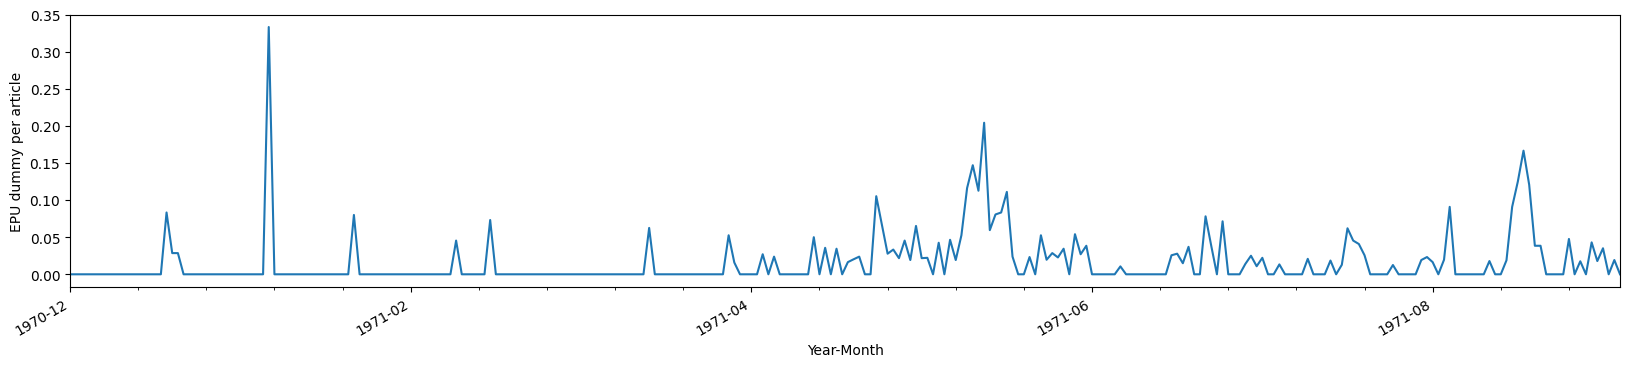

In [17]:
corpus_data['month'] = pd.to_datetime(corpus_data['month_name'], format='%B', errors='coerce').dt.month

# Filter for years 2004 and later (if needed)
corpus_data = corpus_data[corpus_data['year'] >= 1999].copy()

# Create a datetime column from year and month, setting day to 1
corpus_data['date'] = pd.to_datetime(corpus_data[['year', 'month']].assign(day=1))

# Group by the date column and compute the mean of EPU_ind
grouped = corpus_data.groupby('date')['EPU_ind'].mean()

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 4))
grouped.plot(ax=ax)  # marker='o' to highlight data points

# Format the x-axis to show Year-Month
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate(rotation=30, ha='right')

# Label axes
ax.set_xlabel("Year-Month")
ax.set_ylabel("EPU dummy per article")

plt.show()



In [18]:
corpus_data

,year,month,day,section,text,count,is_sport,sport_dummy,text_preproc,Pcount,Ucount,Ecount,Ecount_dummy,Ucount_dummy,Pcount_dummy,EPU_ind,month_name,date
0,2003,7,11,International News,The cry of a muezzin echoed from a hilltop ove...,1,False,0,cry muezzin echoed hilltop overlooking alhambr...,4,0,0,0,0,1,0,July,2003-07-01
1,2003,7,12,International News,"Spain, a leading U.S. ally during the war to o...",1,False,0,spain leading us ally war oust saddam hussein ...,1,0,0,0,0,1,0,July,2003-07-01
2,2003,7,15,Sports News,Yago Lamela of Spain tuned up for next month's...,1,True,1,yago lamela spain tuned next months world cham...,0,0,0,0,0,0,0,July,2003-07-01
3,2003,7,19,International News,"On a quiet summer night in 1977, a gang of 16 ...",1,False,0,quiet summer night 1977 gang 16 hooded soldier...,1,0,0,0,0,1,0,July,2003-07-01
4,2003,7,19,Sports News,"SaturdayAt Estadio de la PeintaMadrid, SpainAl...",1,True,1,saturdayat estadio de la peintamadrid spainall...,0,0,0,0,0,0,0,July,2003-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13470,2016,7,28,INTERNATIONAL NEWS,MADRID (AP) - Acting Prime Minister Mariano Ra...,1,False,0,madrid ap acting prime minister mariano rajoys...,6,0,0,0,0,1,0,July,2016-07-01
13471,2016,7,29,INTERNATIONAL NEWS,MADRID (AP) - Spain's acting Prime Minister Ma...,1,False,0,madrid ap spains acting prime minister mariano...,8,1,0,0,1,1,0,July,2016-07-01
13472,2016,7,29,BUSINESS NEWS,MADRID (AP) - The acting Spanish government ha...,1,False,0,madrid ap acting spanish government revised up...,3,0,2,1,0,1,0,July,2016-07-01
13473,2016,7,29,BUSINESS NEWS,MADRID (AP) - The number of tourists visiting ...,1,False,0,madrid ap number tourists visiting spain jumpe...,0,0,2,1,0,0,0,July,2016-07-01


## Now take into account the intensive margin of word counts...

In [19]:

# First we make matches relative to the total number of words in the dictionary and in the article, how?

corpus_data['total_words'] = corpus_data['text'].str.split().str.len()

# group by date and ssum and mean for the total articles

new_df = corpus_data.groupby('date').agg({'Ecount': 'sum', 'Pcount': 'sum', 'Ucount': 'sum', 'total_words': 'sum'}).reset_index()




for letter in ["E","P","U"]:
    new_df[f'{letter}_rel']=100*(new_df[f'{letter}count']/new_df['total_words'])
    




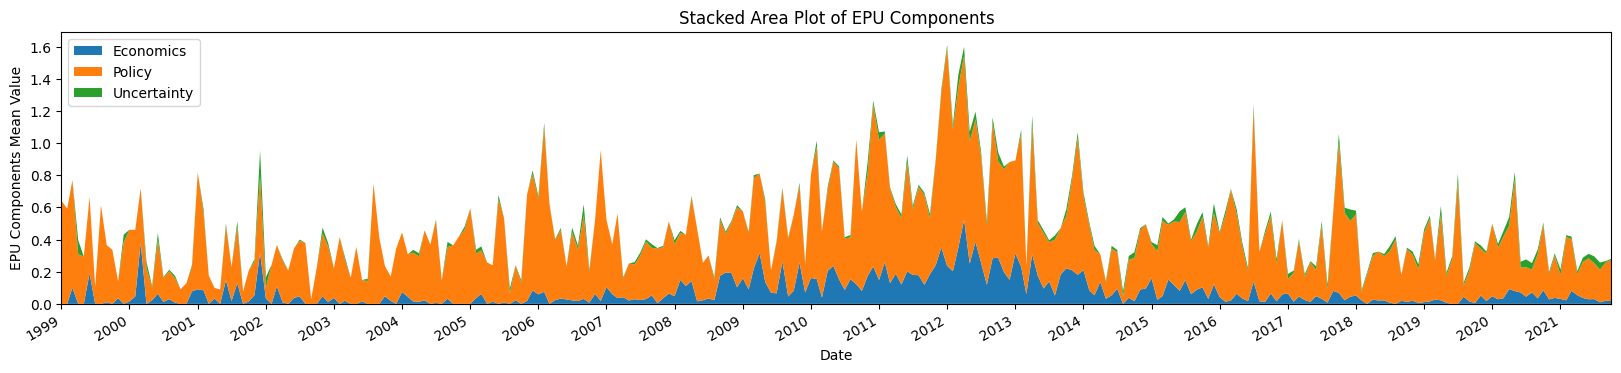

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 4))

# Stackplot
ax.stackplot(new_df['date'], new_df['E_rel'], new_df['P_rel'], new_df['U_rel'], labels=['Economics', 'Policy', 'Uncertainty'])

# Set x-axis limits to start at the first date
ax.set_xlim(new_df['date'].min(), new_df['date'].max())

# Labels and title
plt.xlabel('Date')
plt.ylabel('EPU Components Mean Value')
plt.title('Stacked Area Plot of EPU Components')

# Formatting x-axis
plt.gcf().autofmt_xdate()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Legend
plt.legend(loc='upper left')

# Show the plot
plt.show()

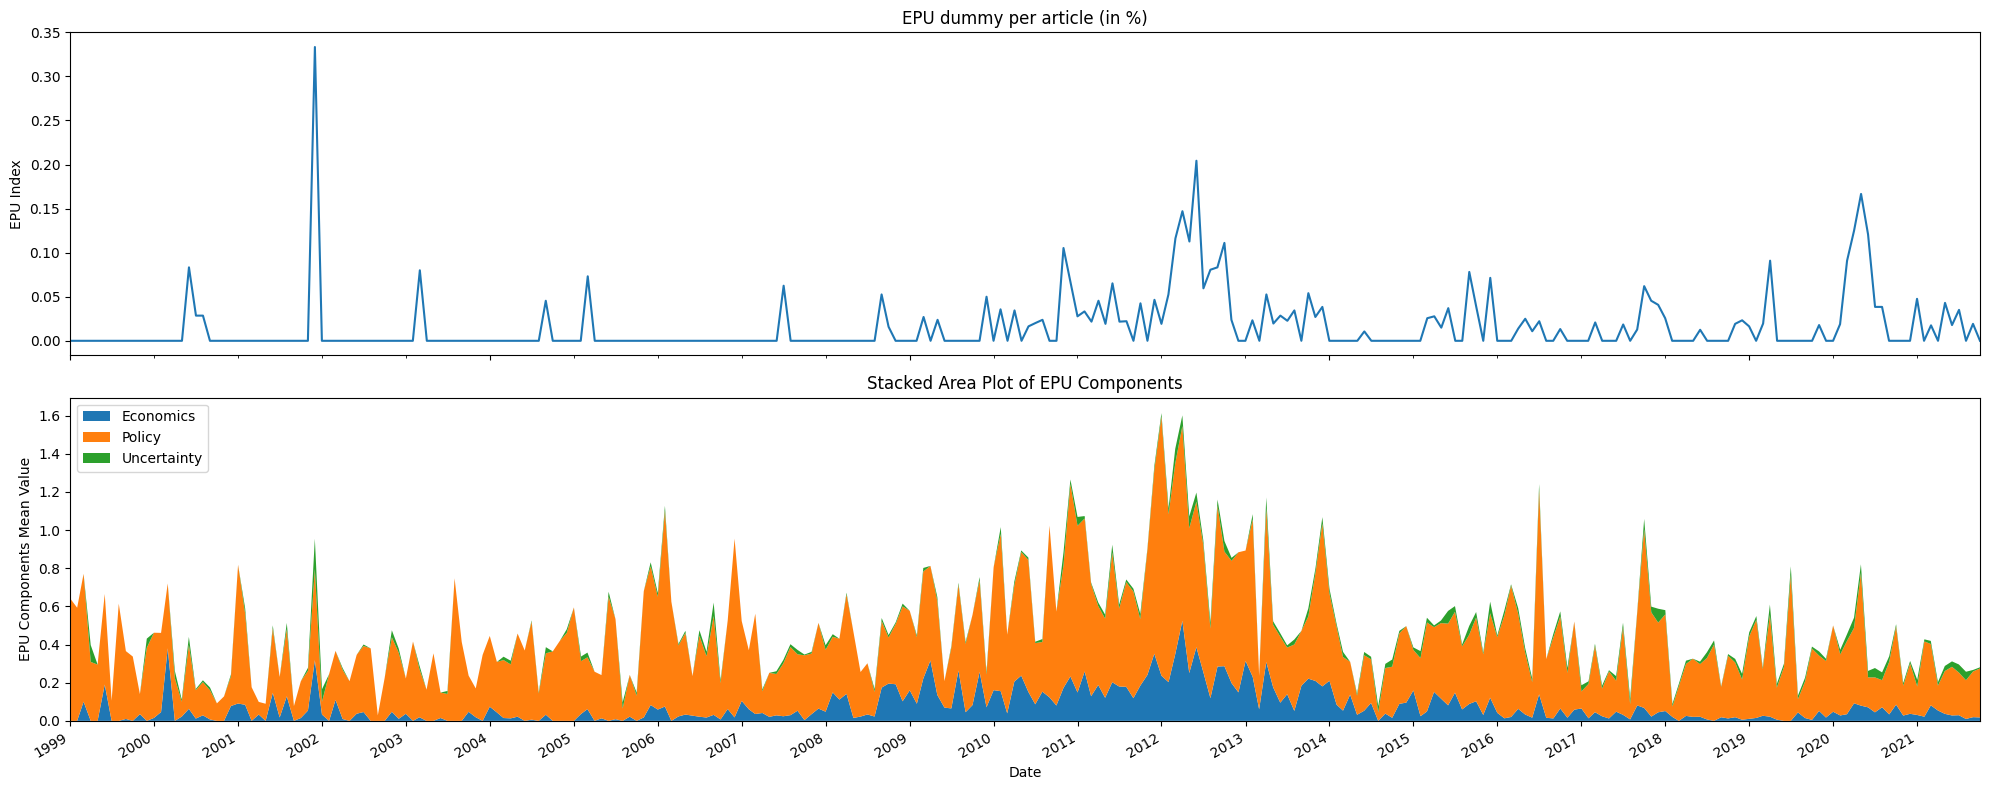

In [21]:



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

corpus_data.groupby(corpus_data['date'])["EPU_ind"].mean().plot(kind='line', ax=ax1)
ax1.set_title("EPU dummy per article (in %)")
ax1.set_xlabel("Year")
ax1.set_ylabel("EPU Index")
for label in ax1.get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
ax2.stackplot(new_df['date'], new_df['E_rel'], new_df['P_rel'], new_df['U_rel'], labels=['Economics', 'Policy', 'Uncertainty'])
ax2.set_title("Stacked Area Plot of EPU Components")
ax2.set_xlabel('Date')
ax2.set_ylabel('EPU Components Mean Value')
plt.gcf().autofmt_xdate()
# Set x-axis limits to start at the first date
ax2.set_xlim(new_df['date'].min(), new_df['date'].max())

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.legend(loc='upper left')

plt.tight_layout()  
plt.show()





#### Why are the two figures different?

The top shows the share from a dummified version where E, P and U need to coincide. The other graph shows relative counts on all three but they do not need to coincide in the same article.